# Protein classification with deep learning using topological features

Build multiclass classifier with TensorFlow using a multilayer perceptron model trained on topological features. Construct SVM as a comparison.

In [1]:
!pip install -q git+https://github.com/azlawson/PersistenceCurves.git
!pip install -q biopython
!pip install -q scikit-tda

In [2]:
import os
import numpy as np
import persistencecurves as pc
import matplotlib.pyplot as plt
import tensorflow as tf

from Bio.PDB import PDBParser
from ripser import ripser
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [3]:
parser = PDBParser(PERMISSIVE=1, QUIET=True)

## Exploratory analysis
Let's look at the number of coordinates to determine how we might want to set Ripster's [n_perm](https://ripser.scikit-tda.org/en/latest/reference/stubs/ripser.ripser.html#ripser.ripser) parameter which controls the number of points to subsample

In [4]:
os.chdir('/content/drive/MyDrive/protein-structure-learning/data')

In [5]:
# Inspect the number of coordinates
n_atoms = np.empty((0, 1), int)
for file in os.listdir("./SCOP40mini"):
    structure_id = os.path.splitext(file)[0]
    structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
    
    # Generate a list of the protein's atoms' coordinates in R^3
    coords = []
    for atom in structure.get_atoms():
        coords.append(list(atom.get_vector()))
    coords = np.array(coords)

    n_atoms = np.append(n_atoms, len(coords))

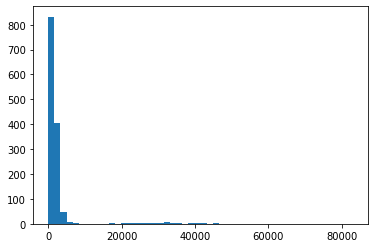

Mean: 3071.304347826087
Median: 1379.0


In [6]:
# Histogram
plt.hist(n_atoms, bins=50)
plt.show()

print('Mean: '+ str(np.mean(n_atoms)))
print('Median: '+ str(np.median(n_atoms)))

## Generate persistence diagrams
This loop is rather time-intensive. We can alternatively load saved diagrams below.

In [ ]:
diagrams = np.empty((0, 300), int) # Use if computing H_0, H_1, and H_2
classes_fold = np.empty((0, 1), str)
classes_superfamily = np.empty((0, 1), str)
classes_family = np.empty((0, 1), str)

for file in os.listdir("./SCOP40mini"):
    structure_id = os.path.splitext(file)[0]
    structure = parser.get_structure(structure_id, "./SCOP40mini/" + file)
    
    # We grab the SCOP sccs to build the classes
    sccs = parser.get_header()['astral']['SCOP-sccs']
    fold = sccs.rsplit('.', 2)[0]
    superfamily = sccs.rsplit('.', 1)[0]
    family = sccs
    
    # Generate a list of the protein's atoms' coordinates in R^3
    coords = []
    for atom in structure.get_atoms():
        coords.append(list(atom.get_vector()))
    coords = np.array(coords)
    
    # Compute persistent homology
    # We use roughly the median number of atoms to set the subsampling threshold 
    if len(coords) > 1300:
        diagram = ripser(coords, maxdim=2, thresh=10, do_cocycles=False, n_perm=1300)['dgms']
    else:
        diagram = ripser(coords, maxdim=2, thresh=10, do_cocycles=False)['dgms']

    # Generate persistence curves from diagrams
    d_h0 = pc.Diagram(Dgm=diagram[0], globalmaxdeath=10, inf_policy='remove')
    d_h1 = pc.Diagram(Dgm=diagram[1], globalmaxdeath=10, inf_policy='remove')
    d_h2 = pc.Diagram(Dgm=diagram[2], globalmaxdeath=10, inf_policy='remove')

    # Generate life curves
    lc_h0 = d_h0.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)
    lc_h1 = d_h1.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)
    lc_h2 = d_h2.lifecurve(meshstart=0, meshstop=10, num_in_mesh=100)

    # Join life curves together
    lc_all = np.concatenate((lc_h0, lc_h1, lc_h2))
    
    diagrams = np.vstack((diagrams, lc_all))
    classes_fold = np.vstack((classes_fold, fold))
    classes_superfamily = np.vstack((classes_superfamily, superfamily))
    classes_family = np.vstack((classes_family, family))

    print(diagrams.shape)

In [ ]:
np.save('./diagrams', diagrams)
np.save('./classes_fold', classes_fold)
np.save('./classes_superfamily', classes_superfamily)
np.save('./classes_family', classes_family)

Set desired SCOP domain classification (e.g., superfamily)

In [ ]:
classes = classes_superfamily

## Load diagrams and classes

In [7]:
diagrams = np.load('diagrams.npy')
classes = np.load('classes_superfamily.npy')

## SVM

Prep data for SVM

In [8]:
# Generate binary targets for an arbitrary class 
# targets = np.ravel(label_binarize(classes, classes=['a.3.1'])) # If binary
targets = np.ravel(classes) # If multiclass
data = diagrams

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2)

Fit SVM

In [9]:
clf = SVC(kernel='rbf', C=20, random_state=42)

# Perform 5-fold cross validation
scores = cross_val_score(clf, data, targets, cv=5)
print('%0.3f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))

# Test accuracy using testing data
# clf = SVC(kernel='rbf', C=20).fit(train_data, train_targets)
#print('Train Accuracy: {acc:0.3f}'.format(acc=clf.score(train_data, train_targets)))
#print('Test Accuracy: {acc:0.3f}'.format(acc=clf.score(test_data, test_targets)))

0.280 accuracy with a standard deviation of 0.02


## MLP 

Prep data for TensorFlow MLP

In [10]:
# Count the number of unique classes
num_classes = len(np.unique(classes))
print(num_classes)

# Prepare targets and data for TensorFlow
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(classes)
targets = one_hot_encoder.transform(classes)
data = diagrams

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2)

24


Define helper funtions

In [11]:
def get_test_accuracy(model, test_data, test_targets):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=test_data, y=test_targets, verbose=0)
    print('Test Accuracy: {acc:0.3f}'.format(acc=test_acc))

In [12]:
# Delete model if it exists
if 'model' in globals():
    del model


### Fit multiclass classifier model

In [13]:
# Build sequential model for superfamily
k_initializer = tf.keras.initializers.he_uniform()
b_initializer = tf.keras.initializers.Ones()

dropout_rate = 0.10

model = Sequential([
    Dense(200, activation = 'relu', 
            input_shape = train_data[0].shape, 
            kernel_initializer=k_initializer,
            bias_initializer=b_initializer),
    Dropout(dropout_rate),
    Dense(200, activation = 'relu'),
    Dense(200, activation = 'relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(num_classes, activation='softmax')
    ])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# Fit model
history = model.fit(train_data, train_targets, 
                    epochs=500, validation_split=0.15, batch_size=200, 
                    verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 52ms/step - loss: 258.4401 - acc: 0.0672 - val_loss: 73.2186 - val_acc: 0.0184
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 81.0847 - acc: 0.0759 - val_loss: 37.6204 - val_acc: 0.1902
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 47.1407 - acc: 0.1020 - val_loss: 17.9257 - val_acc: 0.1902
Epoch 4/500
5/5 [==============================] - 0s 8ms/step - loss: 29.4270 - acc: 0.0998 - val_loss: 9.6094 - val_acc: 0.0736
Epoch 5/500
5/5 [==============================] - 0s 8ms/step - loss: 22.6520 - acc: 0.0781 - val_loss: 8.3394 - val_acc: 0.1779
Epoch 6/500
5/5 [==============================] - 0s 8ms/step - loss: 16.5771 - acc: 0.1009 - val_loss: 7.5235 - val_acc: 0.1534
Epoch 7/500
5/5 [==============================] - 0s 8ms/step - loss: 14.0127 - acc: 0.0987 - val_loss: 5.5079 - val_acc: 0.1288
Epoch 8/500
5/5 [==============================] - 0s 8ms/step - loss: 11.1197 - acc

Let's explore what's going wrong in an arbitrary mistaken classification

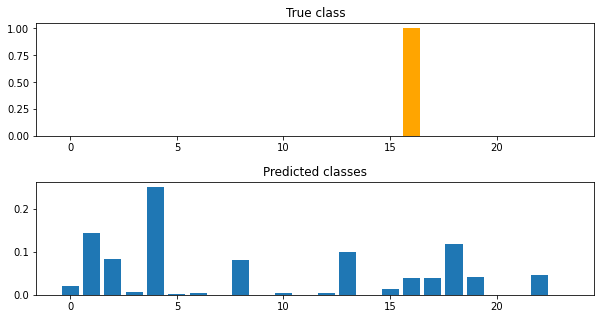

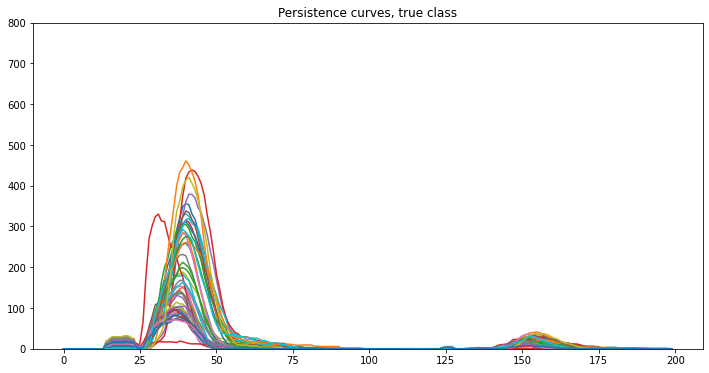

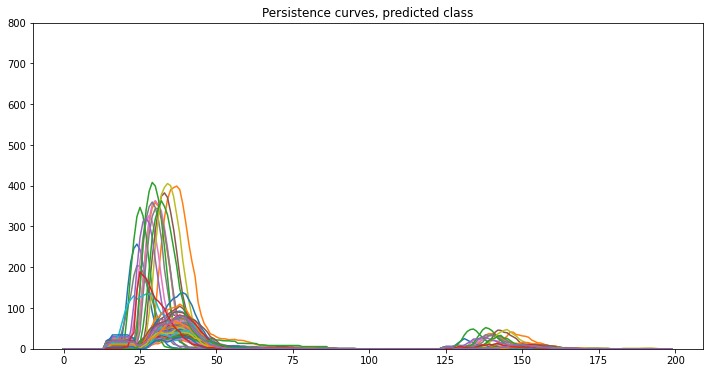

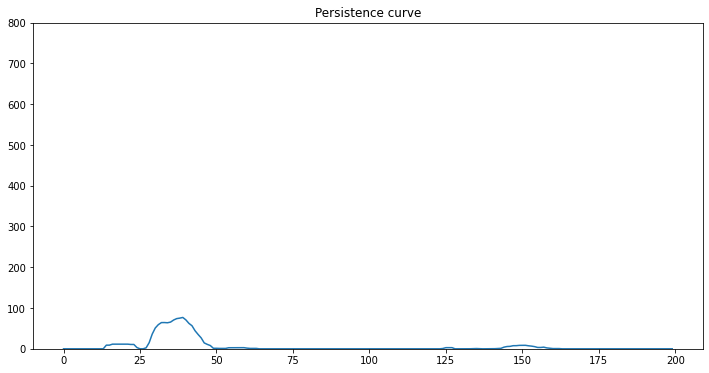

In [14]:
predictions = model.predict(test_data)

i = 1

true_class = test_targets[i]
pred_class = tf.one_hot(tf.argmax(predictions[i]), depth = num_classes).numpy()

true_class_profiles = []
for j in range(0, len(train_targets)):
    if(np.array_equal(train_targets[j], true_class) == True):
        true_class_profiles.append(j)

pred_class_profiles = []
for j in range(0, len(train_targets)):
    if(np.array_equal(train_targets[j], pred_class) == True):
        pred_class_profiles.append(j)  


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.4)
ax[0].bar(np.arange(num_classes), test_targets[i], color='orange')
ax[0].set_title('True class')
ax[1].bar(np.arange(num_classes), predictions[i])
ax[1].set_title('Predicted classes')
plt.show()

homology = range(100, 300)

# Plot all the persistence curves for a given class layered onto one another
fig, ax = plt.subplots(figsize=(12, 6))
for k in true_class_profiles:
    ax.plot(train_data[k, homology])
    ax.set_title('Persistence curves, true class')
plt.ylim([0, 800])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
for k in pred_class_profiles:
    ax.plot(train_data[k, homology])
    ax.set_title('Persistence curves, predicted class')
plt.ylim([0, 800])
plt.show()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data[i, homology])
ax.set_title('Persistence curve')
plt.ylim([0, 800])
plt.show()


### Summarize model performance

In [15]:
model.summary()
get_test_accuracy(model, test_data, test_targets)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               60200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               25728     
                                                                 
 dense_4 (Dense)             (None, 128)               1

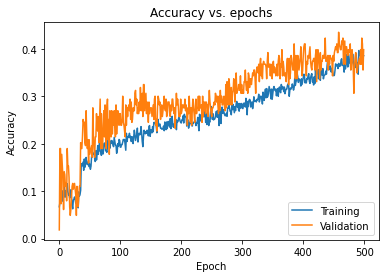

In [16]:
plt.clf()
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()